Source: https://www.kaggle.com/datasets/mvianna10/germany-electricity-power-for-20062017

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [43]:
df_raw = pd.read_csv('./data_raw/opsd_germany_daily.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


In [44]:
df = df_raw.drop(columns=['Wind', 'Solar', 'Wind+Solar'])
df['Date'] = pd.to_datetime(df.Date)

df = df.set_index('Date')

<AxesSubplot: title={'center': 'Germany Energin'}, xlabel='Date'>

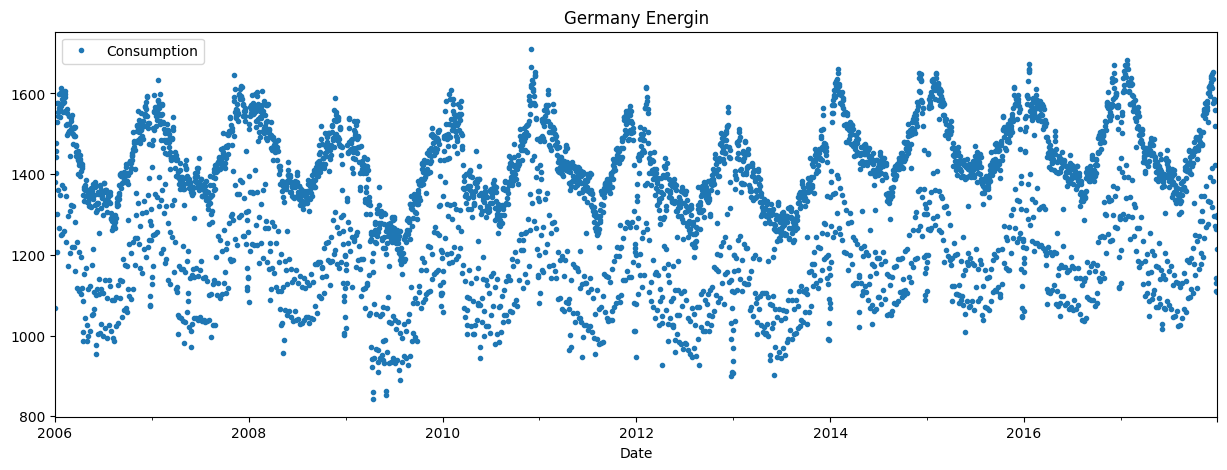

In [45]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Germany Energin')

# Train/ Test Split

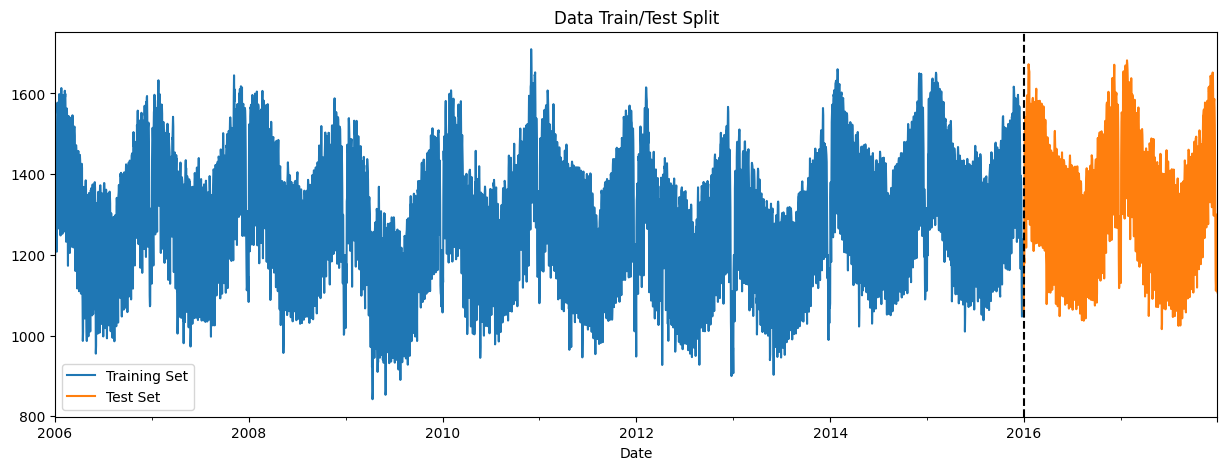

In [46]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, title = 'Data Train/Test Split')
test.plot(ax=ax)
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [47]:
def create_features(df):
    """
    Create time series feature based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['lag'] = df.Consumption.shift(1)
    return df

In [48]:
df = create_features(df)
df.head()

,Consumption,hour,dayofweek,quarter,month,year,dayofyear,is_month_start,is_month_end,lag
Date,,,,,,,,,,
2006-01-01,1069.184,0,6,1,1,2006,1,1,0,NaN
2006-01-02,1380.521,0,0,1,1,2006,2,0,0,1069.184
2006-01-03,1442.533,0,1,1,1,2006,3,0,0,1380.521
2006-01-04,1457.217,0,2,1,1,2006,4,0,0,1442.533
2006-01-05,1477.131,0,3,1,1,2006,5,0,0,1457.217


In [49]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear','is_month_start', 'is_month_end', 'lag']
TARGET = 'Consumption'

In [50]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [51]:
lgb_params = {'num_leaves':10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name= FEATURES)
lgbval = lgb.Dataset(data=X_test, label=y_test, reference=lgbtrain, feature_name= FEATURES)

In [52]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

/home/erica/Documents/germany_electricity_2016_2017/.env/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/erica/Documents/germany_electricity_2016_2017/.env/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/erica/Documents/germany_electricity_2016_2017/.env/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023627 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 3904.26	valid_1's l2: 4189.05
[200]	training's l2: 2210.66	valid_1's l2: 2441.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l2: 1907.54	valid_1's l2: 2136.23
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [53]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

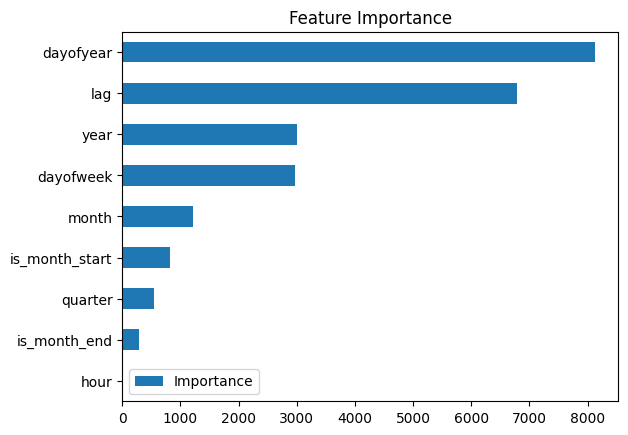

In [54]:
fi = pd.DataFrame(data = model.feature_importance(),
             index=model.feature_name(),
             columns=['Importance'])

fi.sort_values('Importance').plot(kind ='barh', title='Feature Importance')
plt.show()

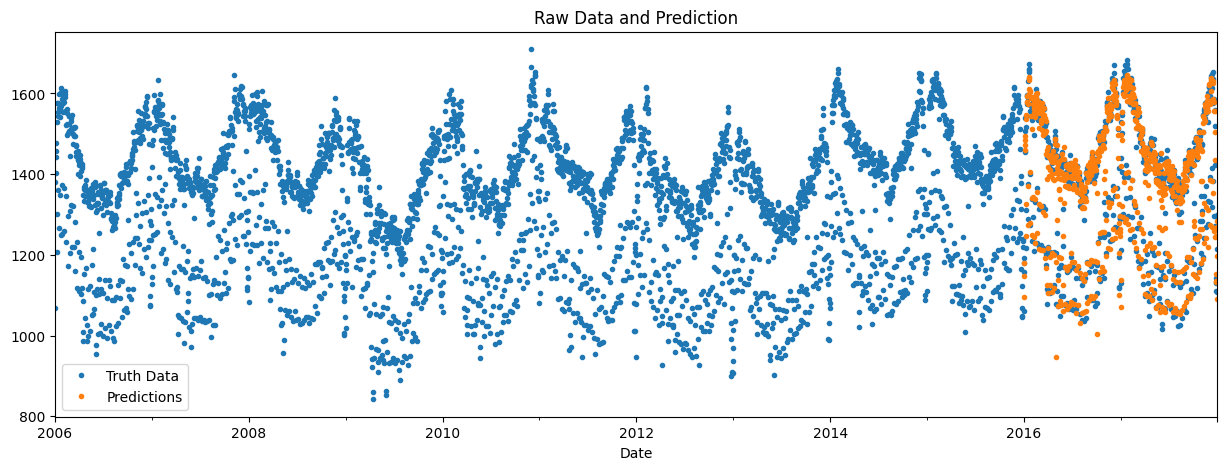

In [55]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Consumption']].plot(figsize=(15,5), style='.')
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [61]:
score = np.sqrt(mean_squared_error(test['Consumption'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 40.10


In [65]:
test['error'] = np.abs(test[TARGET] - test['prediction'])/test[TARGET]

In [68]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2016-05-05    0.274283
2016-03-28    0.245138
2016-05-16    0.239743
2017-05-25    0.238172
2017-04-17    0.233186
2017-06-05    0.226697
2016-10-03    0.224383
2017-04-14    0.213988
2016-03-25    0.207521
2017-10-31    0.148731
Name: error, dtype: float64

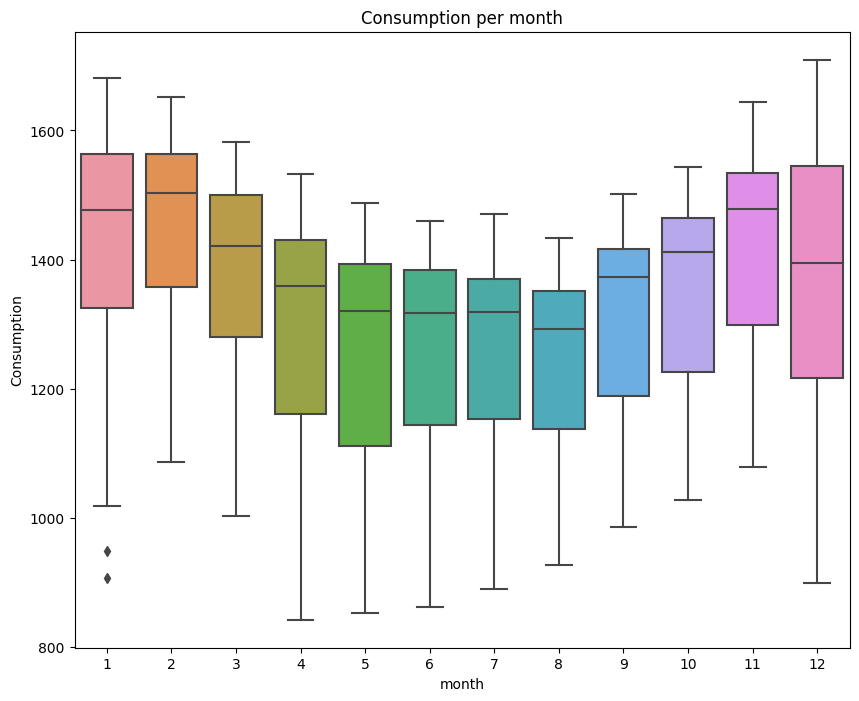

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='Consumption')
ax.set_title('Consumption per month')
plt.show()

In [74]:
df[['Consumption', 'month']].groupby('month').mean()

,Consumption
month,
1,1433.781435
2,1452.463841
3,1380.694497
4,1298.457644
5,1261.905065
6,1263.169508
7,1266.701788
8,1249.991327
9,1314.348716


In [75]:
df[['Consumption', 'month']].groupby('month').std()


,Consumption
month,
1,161.744962
2,140.682177
3,146.327248
4,158.609557
5,157.969471
6,146.373286
7,139.041736
8,130.969571
9,136.621594


In [69]:
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)

date
2016-01-03    0.000012
2016-11-17    0.000024
2016-02-14    0.000055
2017-01-04    0.000058
2017-07-02    0.000087
2016-02-23    0.000088
2017-03-03    0.000111
2017-03-29    0.000122
2016-11-04    0.000167
2016-07-24    0.000170
Name: error, dtype: float64